<a href="https://colab.research.google.com/github/patrickbryant1/BL8064/blob/main/BL8064.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BL8064 Protein structure prediction exercise

Hi and welcome to the protein structure prediction exercise for the course [Methods in Molecular Life Science](https://www.su.se/english/search-courses-and-programmes/bl8064-1.684212).
This exercise is about assessing the impact of mutations using protein structure prediction.
\
\
Did you know that proteins interact to form intricate [signaling networks](https://en.wikipedia.org/wiki/Interactome)?
If mutations occur in the interaction interfaces - these networks can be perturbed resulting in functional changes!
\
\
Here we will assess the impact of mutations of **your choice** on proteins of **your choice** using protein structure prediction of interaction networks.
\
\
Please follow the instructions below.

In [ ]:
#@title Install dependencies
#@markdown Make sure your runtime is GPU.
#@markdown In the menu above do: Runtime --> Change runtime type --> Hardware accelerator (set to GPU)

#@markdown **Press play.**

#@markdown Simply press play on each cell below and follow the instructions.

#@markdown You will have to restart the runtime after this finishes to include the new packages.
#@markdown In the menu above do: Runtime --> Restart runtime \
#@markdown ***Do not restart before all packages are installed.***

#@markdown Don't worry about all the errors that pip give below, these are resolved in the end.
!pip install --upgrade "jax[cuda12_local]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install ml-collections==0.1.1
!pip install dm-haiku==0.0.11
!pip install pandas==1.3.5
!pip install biopython==1.81
!pip install chex==0.1.5
!pip install dm-tree==0.1.8
!pip install immutabledict==2.0.0
!pip install scipy==1.7.3
!pip install tensorflow==2.11.0
!pip install rdkit-pypi
!pip install py3Dmol
!pip install numpy --upgrade

In [101]:
#@title #Map your mutations to the predicted AlphaFold (AF) structure.

#@markdown #Inputs
#@markdown - *ID* - for your protein of interest (POI). This has to be the ID from the [AlphaFoldDB](https://alphafold.ebi.ac.uk/entry/Q6FXU7) (which should be the same as the Uniprot ID). For PDR1 this is Q6FXU7 (you can search the AlphaFoldDB to find this information).
#@markdown - *Mutations* - Provide a list of mutations separated by comma in the form Y270D (amino acid Y at pos 270 is mutated to D). The index is assumed to start at 1.

import sys, os
from google.colab import files
import pandas as pd
import numpy as np
import py3Dmol
import pdb


ID = "Q6FXU7" #@param {type:"string"}
Mutations = "Y270D,F669L,V1048F" #@param {type:"string"}

#Make a result directory
OUTDIR="/content/"+ID+'/'
if not os.path.exists(OUTDIR):
  os.mkdir(OUTDIR)
print('All results will be saved to', OUTDIR)
#Get the structure from the AFDB

if not os.path.exists(OUTDIR+'/AF-'+ID+'-F1-model_v4.pdb'):
  print('Downloading protein of interest')
  !wget https://alphafold.ebi.ac.uk/files/AF-$ID-F1-model_v4.pdb
  !mv /content/AF-$ID-F1-model_v4.pdb $OUTDIR
else:
  print('Protein of interest downloaded')

#Get mutation positions
MUTS = Mutations.split(',')
TARGET_POSITIONS = [int(x[1:-1]) for x in MUTS]

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
view.addModel(open(OUTDIR+'/AF-'+ID+'-F1-model_v4.pdb','r').read(),'pdb')
view.setStyle({'chain':'A'},{'cartoon': {'color':'green'}})


print('Viewing the POI', ID, 'in cartoon style and the positions for the input mutations in magenta spheres.')
print('The structure is coloured by plDDT (confindence - see next section):')
print('Orange: Very low (pLDDT < 50)')
print('Yellow: Low (70 > pLDDT > 50)')
print('Light blue: High (90 > pLDDT > 70)')
print('Dark blue: Very high (pLDDT > 90)')
print('The visualisation is interactive - zoom in and look where your mutations are.')

#Highlight mutations and parse important info
three_to_one = {'ARG':'R', 'HIS':'H', 'LYS':'K', 'ASP':'D', 'GLU':'E',
                    'SER':'S', 'THR':'T', 'ASN':'N', 'GLN':'Q', 'CYS':'C',
                    'GLY':'G', 'PRO':'P', 'ALA':'A', 'ILE':'I', 'LEU':'L',
                    'MET':'M', 'PHE':'F', 'TRP':'W', 'TYR':'Y', 'VAL':'V',
                    'SEC':'U', 'PYL':'O', 'GLX':'Z', 'UNK': 'X'}

structure_plddt = []
structure_sequence = ''
with open(OUTDIR+'/AF-'+ID+'-F1-model_v4.pdb',"r") as ifile:
    system = "".join([x for x in ifile])
i = 0
for line in system.split("\n"):
    split = line.split()
    if len(split) == 0 or split[0] != "ATOM":
        continue
    idx = int(line[22:26])
    plddt = float(line[61:66])
    resi = three_to_one.get(line[17:20])
    #Save plDDT - per residue
    if 'CA' in line:
      structure_plddt.append(plddt)
      structure_sequence+=resi

    if plddt<50:
      color = "orange"
      view.setStyle({'model': -1, 'serial': i+1}, {"cartoon": {'color': color}})
    if (plddt>=50 and plddt<70):
      color = "yellow"
      view.setStyle({'model': -1, 'serial': i+1}, {"cartoon": {'color': color}})
    if (plddt>=70 and plddt<90):
      color = "deepskyblue"
      view.setStyle({'model': -1, 'serial': i+1}, {"cartoon": {'color': color}})
    if plddt>=90:
      color = "blue"
      view.setStyle({'model': -1, 'serial': i+1}, {"cartoon": {'color': color}})

    if idx in TARGET_POSITIONS:
        color = "magenta"
        view.setStyle({'model': -1, 'serial': i+1}, {"sphere": {'color': color}})

    i += 1

view.zoomTo()
view.show()


All results will be saved to /content/Q6FXU7/
Protein of interest downloaded
Viewing the POI Q6FXU7 in cartoon style and the positions for the input mutations in magenta spheres.
The structure is coloured by plDDT (confindence - see next section):
Orange: Very low (pLDDT < 50)
Yellow: Low (70 > pLDDT > 50)
Light blue: High (90 > pLDDT > 70)
Dark blue: Very high (pLDDT > 90)
The visualisation is interactive - zoom in and look where your mutations are.


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [82]:
#@title #Map your mutations to high confidence regions

#@markdown Not all protein regions can be predicted equally well.
#@markdown How well a protein region can be predicted is related to the [coevolution](https://en.wikipedia.org/wiki/Coevolution) in that region - a measure of how important the exact structure of that region is.

#@markdown Here we will map the mutations to high confidence regions based on the predicted [lDDT](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3799472/) (plDDT) from AlphaFold2. The plDDT is a measure of how confident the network is in that a structural region is predicted accurately (higher=better).

#@markdown We will use a cutoff of 80 to assess mutations only in high confidence regions.

#@markdown - *plDDT* - a measure of structural confidence (default=80)

cutoff = 80 # @param {type:"integer"}

#Filter structure by plDDT
structure_plddt = np.array(structure_plddt)
filtered_pos = np.argwhere(structure_plddt>cutoff)[:,0]+1 #Add one - first pos is 1

filtered_inds = []
filtered_plddts = []
for i in range(len(TARGET_POSITIONS)):
  if TARGET_POSITIONS[i] in filtered_pos:
    filtered_inds.append(i)
    filtered_plddts.append(structure_plddt[TARGET_POSITIONS[i]-1])

SEL_MUTS = [MUTS[x] for x in filtered_inds]
SEL_TARGET_POSITIONS = [TARGET_POSITIONS[x] for x in filtered_inds]

plddt_df = pd.DataFrame()
plddt_df['mut'] = SEL_MUTS
plddt_df['position'] = SEL_TARGET_POSITIONS
plddt_df['plddt'] = filtered_plddts


view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
view.addModel(open(OUTDIR+'/AF-'+ID+'-F1-model_v4.pdb','r').read(),'pdb')
view.setStyle({'chain':'A'},{'cartoon': {'color':'green'}})


print("Now let's look at what mutations remain after the plDDT filtering.")
print('The remaining mutations are')
print(plddt_df)
#Highlight
with open(OUTDIR+'/AF-'+ID+'-F1-model_v4.pdb',"r") as ifile:
    system = "".join([x for x in ifile])
i = 0
for line in system.split("\n"):
    split = line.split()
    if len(split) == 0 or split[0] != "ATOM":
        continue
    idx = int(line[22:26])

    plddt = float(line[61:66])

    if plddt<50:
      color = "orange"
      view.setStyle({'model': -1, 'serial': i+1}, {"cartoon": {'color': color}})
    if (plddt>=50 and plddt<70):
      color = "yellow"
      view.setStyle({'model': -1, 'serial': i+1}, {"cartoon": {'color': color}})
    if (plddt>=70 and plddt<90):
      color = "deepskyblue"
      view.setStyle({'model': -1, 'serial': i+1}, {"cartoon": {'color': color}})
    if plddt>=90:
      color = "blue"
      view.setStyle({'model': -1, 'serial': i+1}, {"cartoon": {'color': color}})

    if idx in SEL_TARGET_POSITIONS:
        color = "magenta"
        view.setStyle({'model': -1, 'serial': i+1}, {"sphere": {'color': color}})

    i += 1

view.zoomTo()
view.show()

Now let's look at what mutations remain after the plDDT filtering.
The remaining mutations are
     mut  position  plddt
0  F669L       669  98.24


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In total, there are 10 pairwise interactions for PDR1 (Q6FXU7) in STRING.


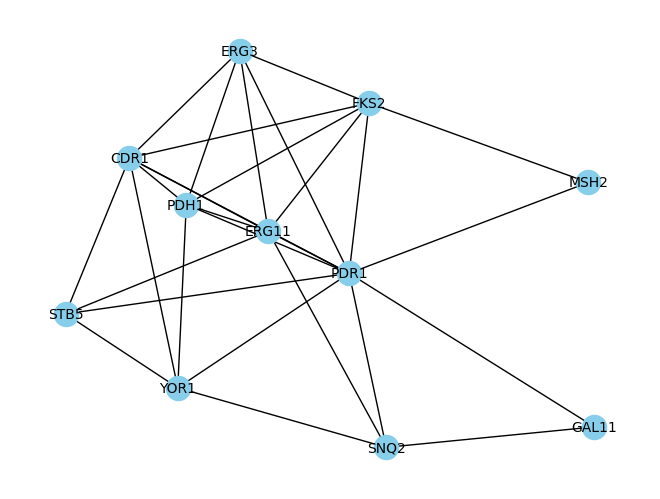

In [77]:
#@title #Get the known interaction network for your POI

import networkx as nx

#@markdown We will use the database [STRING](https://string-db.org/) to narrow down the search space for our POI.

#@markdown STRING (Search Tool for the Retrieval of Interacting Genes/Proteins) is a biological database and web resource of known and predicted protein–protein interactions.

#@markdown 1. Go to [STRING](https://string-db.org/) and search for your ID. You will see a visualisation of your interaction network.

#@markdown 2. Now, download the interactions. Go to 'Exports' and click 'as short tabular text output'.

#@markdown 3. Upload the interaction network here. Click the folder icon (Files) to the left and select the upload file icon. Upload the tsv file. The file should be named: "string_interactions_short.tsv".

#@markdown 4. The ID in STRING will likely be something else than the Uniprot ID. Please input the STRING ID below (centre of network visualisation).

#@markdown 5. Press play to have a look at the interactions.

STRING_ID = "PDR1" #@param {type:"string"}

if os.path.exists('/content/string_interactions_short.tsv'):
  string_df = pd.read_csv('/content/string_interactions_short.tsv', sep='\t')
else:
  print('Please upload the interaction network first')

#Select the part of the network that contains interactions with STRING ID
string_sel = string_df[(string_df['#node1']==STRING_ID)|(string_df['node2']==STRING_ID)]
print('In total, there are',len(sel), 'pairwise interactions for', STRING_ID,'('+ID+')', 'in STRING.')

#Create a graph with NetworkX
G = nx.Graph() # Create an empty undirected graph (or nx.DiGraph() for a directed graph)
# Add nodes from the 'source' and 'target' columns
G.add_nodes_from(string_df['#node1'])
G.add_nodes_from(string_df['node2'])
# Add edges from the DataFrame
edges = [(row['#node1'], row['node2']) for index, row in string_df.iterrows()]
G.add_edges_from(edges)
# Draw the graph
pos = nx.spring_layout(G) # Define the layout for node positioning
nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=10, font_color='black')


In [81]:
#@markdown Let's have a look at the information we get from STRING for the POI.

#@markdown You can see that STRING provides a 'combined score' measuring how likely the interaction is to be accurate. \
#@markdown There is also a column for 'experimentally determined interaction'.

string_sel

#node1 node2 node1_string_id node2_string_id  neighborhood_on_chromosome  \
6    CDR1  PDR1   284593.Q6FK23   284593.Q6FXU7                           0   
9   ERG11  PDR1   284593.P50859   284593.Q6FXU7                           0   
15   ERG3  PDR1   284593.P50860   284593.Q6FXU7                           0   
18   FKS2  PDR1   284593.Q6FMZ3   284593.Q6FXU7                           0   
20  GAL11  PDR1   284593.Q6FRS9   284593.Q6FXU7                           0   
21   MSH2  PDR1   284593.Q6FQA9   284593.Q6FXU7                           0   
23   PDH1  PDR1   284593.O74208   284593.Q6FXU7                           0   
24   PDR1  SNQ2   284593.Q6FXU7   284593.Q6FQN3                           0   
25   PDR1  STB5   284593.Q6FXU7   284593.Q6FQY1                           0   
26   PDR1  YOR1   284593.Q6FXU7   284593.Q6FTR9                           0   

    gene_fusion  phylogenetic_cooccurrence  homology  coexpression  \
6             0                        0.0       0.0         0.177   
9             0                        0.0       0.0         0.000   
15            0                        0.0       0.0         0.000   
18            0                        0.0       0.0         0.053   
20            0                        0.0       0.0         0.041   
21            0                        0.0       0.0         0.049   
23            0                        0.0       0.0         0.058   
24            0                        0.0       0.0         0.091   
25            0                        0.0       0.0         0.000   
26            0                        0.0       0.0         0.193   

    experimentally_determined_interaction  database_annotated  \
6                                   0.182               0.000   
9                                   0.000               0.000   
15                                  0.208               0.000   
18                                  0.000               0.000   
20                                  0.390               0.149   
21                                  0.000               0.000   
23                                  0.182               0.000   
24                                  0.148               0.000   
25                                  0.160               0.000   
26                                  0.154               0.160   

    automated_textmining  combined_score  
6                  0.775           0.835  
9                  0.758           0.758  
15                 0.567           0.642  
18                 0.709           0.712  
20                 0.596           0.772  
21                 0.630           0.633  
23                 0.763           0.801  
24                 0.775           0.811  
25                 0.602           0.651  
26                 0.763           0.846

In [85]:
#@markdown Now we can filter the obtained interactions based on these scores to narrow down the search space further.

experimentally_determined_interaction_cutoff = 0 # @param {type:"number"}
combined_score_cutoff = 0.7 # @param {type:"number"}

string_sel_cutoff = string_sel[(string_sel.experimentally_determined_interaction>experimentally_determined_interaction_cutoff)&(string_sel.combined_score>combined_score_cutoff)]
print('Remaining number of interactions:',len(string_sel_cutoff))
string_sel_cutoff

Remaining number of interactions: 5


#node1 node2 node1_string_id node2_string_id  neighborhood_on_chromosome  \
6    CDR1  PDR1   284593.Q6FK23   284593.Q6FXU7                           0   
20  GAL11  PDR1   284593.Q6FRS9   284593.Q6FXU7                           0   
23   PDH1  PDR1   284593.O74208   284593.Q6FXU7                           0   
24   PDR1  SNQ2   284593.Q6FXU7   284593.Q6FQN3                           0   
26   PDR1  YOR1   284593.Q6FXU7   284593.Q6FTR9                           0   

    gene_fusion  phylogenetic_cooccurrence  homology  coexpression  \
6             0                        0.0       0.0         0.177   
20            0                        0.0       0.0         0.041   
23            0                        0.0       0.0         0.058   
24            0                        0.0       0.0         0.091   
26            0                        0.0       0.0         0.193   

    experimentally_determined_interaction  database_annotated  \
6                                   0.182               0.000   
20                                  0.390               0.149   
23                                  0.182               0.000   
24                                  0.148               0.000   
26                                  0.154               0.160   

    automated_textmining  combined_score  
6                  0.775           0.835  
20                 0.596           0.772  
23                 0.763           0.801  
24                 0.775           0.811  
26                 0.763           0.846

In [109]:
#@markdown Let's get the sequences for the selected interactions. Go back to the STRING search from before and download 'protein sequences' instead (MFA: multi-fasta format - containing the aminoacid sequences in the network). \
#@markdown Upload the file here in the same way as before.

#@markdown Press play and let's check the sequences.

def parse_fasta(filename):
  """Parse fasta file from STRING
  """

  fasta_df = {'STRING_ID':[], 'Sequence':[]}
  seq=''
  with open(filename, 'r') as file:
    for line in file:
      line = line.rstrip()
      if line[0]=='>':
        if len(fasta_df['STRING_ID'])>0:
          fasta_df['Sequence'].append(seq)
          seq=''
        fasta_df['STRING_ID'].append(line.split()[1][1:-1])

      else:
        seq+=line

    fasta_df['Sequence'].append(seq)
  return pd.DataFrame.from_dict(fasta_df)

fasta_df = parse_fasta('/content/string_protein_sequences.fa')

#Check if length matches with structure from AFDB
fasta_df['sequence_length']=[len(x) for x in fasta_df.Sequence]
fasta_df


STRING_ID                                           Sequence  \
0       CDR1  MSLASDKKDADVASTTTTAQDDDNLSTYHGFDHHVQDQVRQLARTL...   
1      ERG11  MSTENTSLVVELLEYVKLGLSYFQALPLAQRVSIMVALPFVYTITW...   
2       ERG3  MDLVLETLDHYIFDDVYAKIAPVELQRGIDDSLVNALSLNKIVSNS...   
3       FKS2  MSYDQGGNGNWQNTDPNGNYYYNGAENNEFYDQDYASQQPEQQQGG...   
4      GAL11  MSSKETIPMHQRSQNVAELLTVLMDINKINGGDSTTAEKMKVHAKS...   
5       MSH2  MASNRPELKFSDISEERGFYKRYVKLPEKPSGTVRIVDKGDYYTAV...   
6       PDH1  MNTPDDSSVSSVDSHQPYMGFDDNVEKRIRELARSLTQQSLTSSNR...   
7       PDR1  MQTLETTSKSNPGEVKAQKPSTRRTKVGKACDSCRRRKIKCNGLKP...   
8       SNQ2  MSSSSEISVAGSDVSFEGRLTQHGRHEETPADQLTKILSGRSHEDA...   
9       STB5  MSGPDKGSDSGQTANDPKQKKARNGQMETYSCARCRKLKKKCPRQL...   
10      YOR1  MLRKDSAAAGSGGDSDSYDQEHKRVSTSSESPQGSTAGKAKTASPV...   

    sequence_length  
0              1499  
1               533  
2               364  
3              1897  
4              1095  
5               957  
6              1542  
7              1107  
8              1507  
9              1005  
10             1477

In [110]:
#@markdown You can see that the length varies between the different proteins. If the proteins are too big we can't predict them (limit of a combined 1000 residues here on the web). \
#@markdown Let's see how big the proteins we selected are

#@markdown Press play and let's check the sequences.

sel_ids = np.unique(np.concatenate([string_sel_cutoff['#node1'].values, string_sel_cutoff['node2'].values]))
sel_seqs = fasta_df[fasta_df.STRING_ID.isin(sel_ids)]
sel_seqs



STRING_ID                                           Sequence  \
0       CDR1  MSLASDKKDADVASTTTTAQDDDNLSTYHGFDHHVQDQVRQLARTL...   
4      GAL11  MSSKETIPMHQRSQNVAELLTVLMDINKINGGDSTTAEKMKVHAKS...   
6       PDH1  MNTPDDSSVSSVDSHQPYMGFDDNVEKRIRELARSLTQQSLTSSNR...   
7       PDR1  MQTLETTSKSNPGEVKAQKPSTRRTKVGKACDSCRRRKIKCNGLKP...   
8       SNQ2  MSSSSEISVAGSDVSFEGRLTQHGRHEETPADQLTKILSGRSHEDA...   
10      YOR1  MLRKDSAAAGSGGDSDSYDQEHKRVSTSSESPQGSTAGKAKTASPV...   

    sequence_length  
0              1499  
4              1095  
6              1542  
7              1107  
8              1507  
10             1477

In [120]:
#@markdown Now we can crop the target sequence around the region of interest for our POI (the mutations) before running the structure prediction.
#@markdown We will use a length cutoff of 500, but you can set this as you wish. The crop will put the mutation in the middle of the crop region.
sequence_length_cutoff = 500 # @param {type:"number"}

#@markdown It is important to make sure that the sequence from Uniprot (used for the AlphaFold2 prediction) and the one we got from STRING match. Press play to check.
string_poi_seq = sel_seqs[sel_seqs.STRING_ID==STRING_ID].Sequence.values[0]
if structure_sequence != string_poi_seq:
  print('Sequence mismatch!')
else:
  print('Sequences match')

print('STRING sequence', string_poi_seq)
print('AlphaFold sequence', structure_sequence)

#Crop around the mutations

cs, ce = [], []
for ind, row in plddt_df.iterrows():
  mut_pos = row.position-1
  mut_cs = max(0, int(len(structure_sequence)-sequence_length_cutoff/2))
  cs.append(mut_cs)
  ce.append(min(mut_cs+sequence_length_cutoff,len(structure_sequence)))

plddt_df['cs']=cs
plddt_df['ce']=ce

plddt_df


Sequences match
STRING sequence MQTLETTSKSNPGEVKAQKPSTRRTKVGKACDSCRRRKIKCNGLKPCPSCTIYGCECTYTDAKSTKNLKSNDAGKSKPTGRVSKNKETTRVDKDIRKLEQQYVPINANIHVGPRFPSENILNGYPQCGAPQNNVVGNPLAVNTQCHRGLSETPMSSTFKESNLRDDRLLQSSDTDDMRNGDSEERDLKGSDSENVKSKDNKSDPLIIYKDDTHIESTVNKLTQAVNELKSLQNAPSSIKSSIDAIELQLRNILDNWKPEVDFEKAKINESATTKSLETNLLRNKYTNHVHLTRFRIWIDYKNANKNNHFMGECGFSLAESFFASNQPLVDELFGLYSQVEAFSLQGLGYCVHLYEPYMKTEEAIKLMKETLYIILRFIDICVHHINEESISIANPLETYLRKKHLMPMTPTPRSSYGSPQSASTKSLVSKIIERIPQPFIESVTNVSSLQLLDLRDDESKMFGTLLNMCKSIRRKFDSVMSDYDSIVTEKSEGEQNDGKVTVAEFTSLCEAEEMLLALCYNYYNLTLYSFFEFGTNIEYMEHLLLLLEEQLALDEYYGFEKVLNVAVANAKKMGFHRWEFYVGYEESTAEKRRLLWWKLYNYEKASTMKKGFFSVIDDATVNCLLPKIFRNFGYLDRVEFLENIQKPMDLSVFSDVPISVLCKYGELALTIVTSEFHEKFLYADRYTSIRNSAKPPTLKNQLIKEIVDGIAYTETSYEAIRKQTAKLWDIALGKVTKDKINKEDTAAASKFTLSYEYHRFRLINMADNLIARLMVKPKSDWLISVMKGHLNRLYEHWKVMNEIILSMDNDYSIATTFEYYAPSCLCLATQTFLIVRNMEMDDVKMMVAVYKRFLNLGMFLQSAKVCSLADSHTFRDFSRSFSFITIISRLMIIEFMQIKELTKVEFIEKFSEVCPDLADLPPMLLDPNSCLYFSLLQQIKKSGFTLSFKKILEDARMMDFNYDRNLDS

mut  position  plddt   cs    ce
0  F669L       669  98.24  857  1107

In [122]:
#@title Now we use [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) to predict the putative interacting pairs.
#@markdown Let's write the sequences as specified by their notebook: \
#@markdown Use `:` to specify inter-protein chainbreaks for **modeling complexes**

#Go through all mutation crops
for ind1, row1 in plddt_df.iterrows():
  print('Mut', row1.mut)
  for ind2, row2 in sel_seqs.iterrows():
    if row2.STRING_ID==STRING_ID:
      continue
    else:
      print(STRING_ID+'-'+row2.STRING_ID)
      print(structure_sequence[row1.cs:row1.ce]+':'+row2.Sequence)



Mut F669L
PDR1-CDR1
MFLQSAKVCSLADSHTFRDFSRSFSFITIISRLMIIEFMQIKELTKVEFIEKFSEVCPDLADLPPMLLDPNSCLYFSLLQQIKKSGFTLSFKKILEDARMMDFNYDRNLDSEAIKKCNGEFSKSMPSCTNVSDTTTAVSDNSAKKKASMGSARVNSTDTLTASPLSGLRNQTQLDSKDSVPSLEAYTPIDSVSDVPTGEINVPFPPVYNQNGLDQQTTYNLGTLDEFVNKGDLNELYNSLWGDLFSDVYL:MSLASDKKDADVASTTTTAQDDDNLSTYHGFDHHVQDQVRQLARTLTQQSSLHQKKEHTLPEEGINPIFTNTEADDYNPRLDPTSDEFSSAEWVQNMSNISNSDPDYYKPYSLGCYWKDLVATGESADIEYQANFLNGPYKGLKTVYNTVVPSTASSKDKNFKILKSMEGAVNPGELLVVLGRPGSGCTTLLKSISSNTHGFNIAKESTISYSGMTPNDIRKHFRGEVVYNAEADIHLPHLTVYQTLLTVARLKTPQNRLKGIDRETYARHLTEVAMATFGLSHTRNTKVGNDLVRGVSGGERKRVSIAEVSICGSKFQCWDNATRGLDSATALEFIRALKVQASISNAAATVAIYQCSQDAYDLFDKVCVLYDGYQIYFGPAGKAKEYFQKMGYVSPERQTTADFLTAVTSPSERIINQDYINRGIFVPQTPKEMWEYWRASEDHADLIKEIDSKLSDNYDANLAEIKDAHVARQSKRARPSSPYTVSYGMQIKYLLIRNFWRIKQSSGVTLFMVIGNSSMAFILGSMFYKVMKHNTTSTFYFRGAAMFFAVLFNAFSSLLEIFSLFEARPITEKHRTYSLYHPSADAFASILSEVPAKLITAVCFNIIYYFLVNFRRNGGVFFFYFLINIVAVFAMSHLFRCVGSVSKTLSAAMVPASMLLLGLSMYSGFAIPRTKILGWSKWIWYINPLAYLFESLMINEFHDRKFPCSQYIPSGSVYNNVPADSR

In [118]:
#@markdown Go to [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) to predict the putative interacting pairs.


STRING_ID                                           Sequence  \
0       CDR1  MSLASDKKDADVASTTTTAQDDDNLSTYHGFDHHVQDQVRQLARTL...   
4      GAL11  MSSKETIPMHQRSQNVAELLTVLMDINKINGGDSTTAEKMKVHAKS...   
6       PDH1  MNTPDDSSVSSVDSHQPYMGFDDNVEKRIRELARSLTQQSLTSSNR...   
7       PDR1  MQTLETTSKSNPGEVKAQKPSTRRTKVGKACDSCRRRKIKCNGLKP...   
8       SNQ2  MSSSSEISVAGSDVSFEGRLTQHGRHEETPADQLTKILSGRSHEDA...   
10      YOR1  MLRKDSAAAGSGGDSDSYDQEHKRVSTSSESPQGSTAGKAKTASPV...   

    sequence_length  
0              1499  
4              1095  
6              1542  
7              1107  
8              1507  
10             1477